# # MDD with 3D dataset - local reflection response visualization at depth level

### Author: M.Ravasi

This notebook is used to visualize the local reflection responses estimated at a chosen depth level for a grid of subsurface points produced by `MDD.py`.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import dask.array as da
import pylops
import pylops_distributed

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from dask.distributed import Scheduler, Client

from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *

from pylops.utils import dottest
from pylops_distributed.utils import dottest as ddottest
from pylops_distributed.optimization.cg import cg as dcg
from pylops_distributed.optimization.cg import cgls as dcgls

In [2]:
os.environ["STORE_PATH"] = "/project/fsenter/mrava/Marchenko3D/"

In [3]:
subsampling = 4

vsz = 650
nvsx = 71
dvsx = 20
ovsx = 200
nvsy = 41
dvsy = 20
ovsy = 200

ivsplot = 21*41+19 # 21*41+19 same as vs
itmax = 250

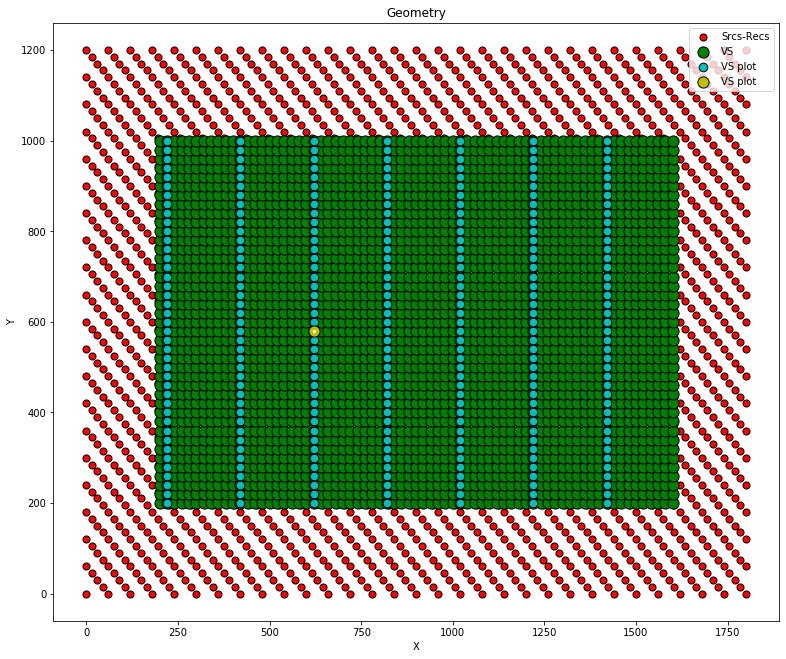

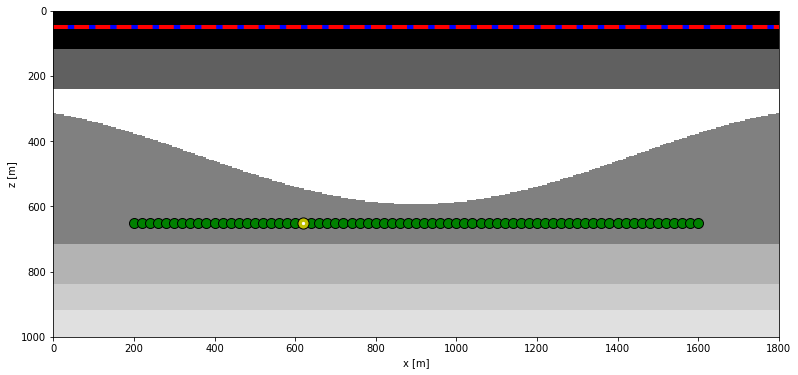

In [4]:
inputfile_aux = os.environ["STORE_PATH"] + '3DMarchenko_auxiliary_2.npz' 

# Load input
inputdata_aux = np.load(inputfile_aux)

# Receivers
r = inputdata_aux['recs'][::subsampling].T
nr = r.shape[1]
dr = r[0,1]-r[0,0]

# Sources
s = inputdata_aux['srcs'][::subsampling].T
ns = s.shape[1]
ds = s[0,1]-s[0,0]

# Virtual points
vs = inputdata_aux['vs'] 
vsy = np.arange(nvsy) * dvsy + ovsy 
vsx = np.arange(nvsx) * dvsx + ovsx 
VSX, VSY = np.meshgrid(vsx, vsy, indexing='ij')

# Time axis
ot, dt, nt = 0, 2.5e-3, itmax #601
t = np.arange(nt)*dt
t = t[:itmax]

# Velocity and Density model
vel = 2400.
rho = inputdata_aux['rho']
z, x, y = inputdata_aux['z'], inputdata_aux['x'], inputdata_aux['y']

# Display geometry
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(13, 11))      
ax.scatter(r[0], r[1], marker='.', s=200, c='r', edgecolors='k', label='Srcs-Recs')
ax.scatter(VSX.ravel(), VSY.ravel(), marker='.', s=500, c='g', edgecolors='k', label='VS')
ax.scatter(VSX[1::10], VSY[1::10], marker='.', s=300, c='c', edgecolors='k', label='VS plot')
ax.scatter(VSX.ravel()[ivsplot:ivsplot+1], VSY.ravel()[ivsplot:ivsplot+1], marker='.', s=500, 
           c='y', edgecolors='k', label='VS plot')
ax.scatter(vs[0], vs[1], marker='.', s=20, c='w')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Geometry')
plt.legend()
plt.show()

fig, ax1 = plt.subplots(1, 1, figsize=(13, 6))
ax1.imshow(rho[np.argmin(np.abs(y-VSY.ravel()[ivsplot]))].T, cmap='gray', vmin=1000, vmax=5000,
           extent = (x[0], x[-1], z[-1], z[0]))
ax1.axhline(r[2, 0], color='b', lw=4)
ax1.axhline(s[2, 0], color='r', linestyle='--', lw=4)
ax1.scatter(vsx, vsz * np.ones(nvsx), marker='.', s=400, c='g', edgecolors='k')
ax1.scatter(VSX.ravel()[ivsplot], vsz * np.ones(1), marker='.', s=500, c='y', edgecolors='k')
ax1.scatter(vs[0], vs[2], marker='.', s=20, c='w')
ax1.axis('tight')
ax1.set_xlabel('x [m]')
ax1.set_ylabel('z [m]')
ax1.set_xlim(x[0], x[-1]);

## Local responses

In [5]:
RSs_adj = da.from_zarr(os.environ["STORE_PATH"] + 'R_Ss_adj_sub%d.zarr' % subsampling)[:itmax].compute()
RSs_inv = da.from_zarr(os.environ["STORE_PATH"] + 'R_Ss_inv_sub%d.zarr' % subsampling)[:itmax].compute()

RMck_adj = da.from_zarr(os.environ["STORE_PATH"] + 'R_Mck_adj_sub%d.zarr' % subsampling)[:itmax].compute()
RMck_inv = da.from_zarr(os.environ["STORE_PATH"] + 'R_Mck_inv_sub%d.zarr' % subsampling)[:itmax].compute()

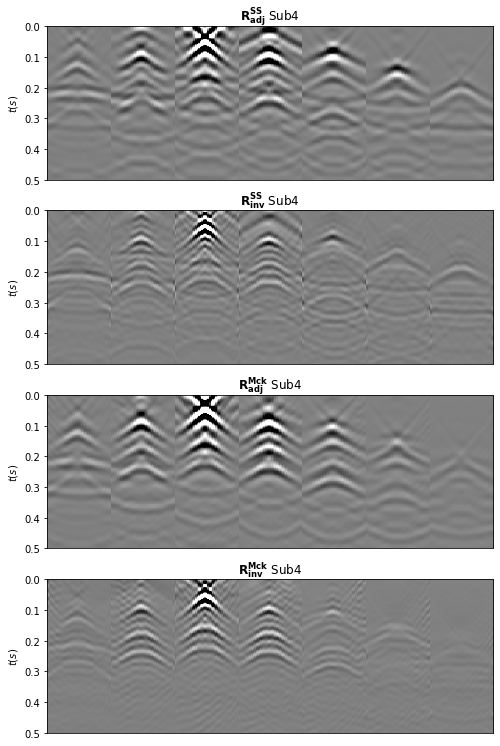

In [6]:
clip_adj = 5e-2
clip_inv = 1e-1

fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, sharex=True, figsize=(8, 13))
ax0.imshow(RSs_adj[..., ivsplot].reshape(nt, nvsx, nvsy)[:, 1::10].reshape(nt, nvsy*7), 
           cmap='gray',
           vmin=-clip_adj*RSs_adj.max(), vmax=clip_adj*RSs_adj.max(),
           extent=(0, nvsx*nvsy, t.max(), 0))
ax0.axis('tight')
ax0.set_ylabel(r'$t(s)$')
ax0.set_title(r'$\mathbf{R^{SS}_{adj}}$ Sub%d' % subsampling)
ax0.set_xticks([], [])
ax0.set_ylim(0.5, 0.)

ax1.imshow(RSs_inv[..., ivsplot].reshape(nt, nvsx, nvsy)[:, 1::10].reshape(nt, nvsy*7),
           cmap='gray',
           vmin=-clip_inv*RSs_inv.max(), vmax=clip_inv*RSs_inv.max(),
           extent=(0, nvsx*nvsy, t.max(), 0))
ax1.axis('tight')
ax1.set_ylabel(r'$t(s)$')
ax1.set_title(r'$\mathbf{R^{SS}_{inv}}$ Sub%d' % subsampling)
ax1.set_ylim(0.5, 0.)

ax2.imshow(RMck_adj[..., ivsplot].reshape(nt, nvsx, nvsy)[:, 1::10].reshape(nt, nvsy*7), 
           cmap='gray',
           vmin=-clip_adj*RMck_adj.max(), vmax=clip_adj*RMck_adj.max(),
           extent=(0, nvsx*nvsy, t.max(), 0))
ax2.axis('tight')
ax2.set_ylabel(r'$t(s)$')
ax2.set_title(r'$\mathbf{R^{Mck}_{adj}}$ Sub%d' % subsampling)
ax2.set_ylim(0.5, 0.)

ax3.imshow(RMck_inv[..., ivsplot].reshape(nt, nvsx, nvsy)[:, 1::10].reshape(nt, nvsy*7),
           cmap='gray',
           vmin=-clip_inv*RMck_inv.max(), vmax=clip_inv*RMck_inv.max(),
           extent=(0, nvsx*nvsy, t.max(), 0))
ax3.axis('tight')
ax3.set_ylabel(r'$t(s)$')
ax3.set_title(r'$\mathbf{R^{Mck}_{inv}}$ Sub%d' % subsampling)
ax3.set_ylim(0.5, 0.)
plt.savefig('Figures/R_mdd_sub%d.eps' % subsampling, bbox_inches='tight')
plt.savefig('Figures/R_mdd_sub%d.png' % subsampling, dpi=300, bbox_inches='tight')

## 3D images

In [7]:
iSs_adj = np.zeros((nvsy*nvsx, nt))
iSs_inv = np.zeros((nvsy*nvsx, nt))

iMck_adj = np.zeros((nvsy*nvsx, nt))
iMck_inv = np.zeros((nvsy*nvsx, nt))

In [8]:
for i in range(nvsy*nvsx):
    iSs_adj[i] = RSs_adj[:, i, i]
    iSs_inv[i] = RSs_inv[:, i, i]
    iMck_adj[i] = RMck_adj[:, i, i]
    iMck_inv[i] = RMck_inv[:, i, i]

In [9]:
iSs_adj = iSs_adj.reshape(nvsx, nvsy, nt)
iSs_inv = iSs_inv.reshape(nvsx, nvsy, nt)
iMck_adj = iMck_adj.reshape(nvsx, nvsy, nt)
iMck_inv = iMck_inv.reshape(nvsx, nvsy, nt)

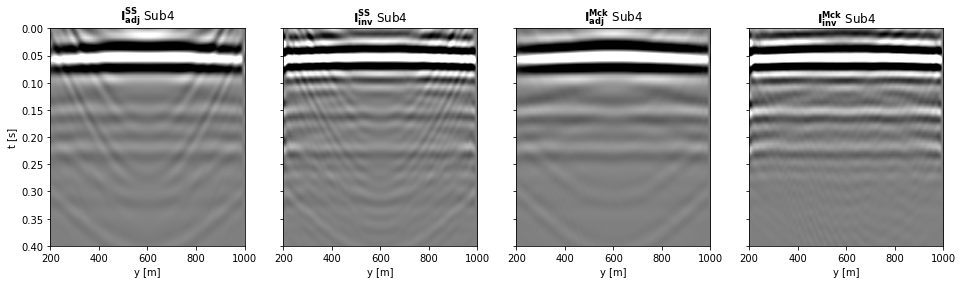

In [10]:
clip_adj=2e-1
clip_inv=2e-1
ivsy_plot = nvsy // 2
ivsx_plot = nvsx // 2

fig, axs = plt.subplots(1, 4, sharey=True, figsize=(16, 4))
axs[0].imshow(iSs_adj[:, ivsx_plot].T, cmap='gray', interpolation='sinc',
              extent=(vsy[0], vsy[-1], t[-1], 0),
              vmin=-clip_adj*iSs_adj.max(), vmax=clip_adj*iSs_adj.max())
axs[0].set_ylabel('t [s]')
axs[0].set_xlabel('y [m]')
axs[0].set_title(r'$\mathbf{I^{SS}_{adj}}$ Sub%d' % subsampling)
axs[0].axis('tight')
axs[0].set_ylim(0.5, 0)
axs[1].imshow(iSs_inv[:, ivsx_plot].T, cmap='gray', interpolation='sinc',
              extent=(vsy[0], vsy[-1], t[-1], 0),
              vmin=-clip_inv*iSs_inv.max(), vmax=clip_inv*iSs_inv.max())
axs[1].set_xlabel('y [m]')
axs[1].set_title(r'$\mathbf{I^{SS}_{inv}}$ Sub%d' % subsampling)
axs[1].axis('tight')
axs[1].set_ylim(0.5, 0)
axs[2].imshow(iMck_adj[:, ivsx_plot].T, cmap='gray', interpolation='sinc',
              extent=(vsy[0], vsy[-1], t[-1], 0),
              vmin=-clip_adj*iMck_adj.max(), vmax=clip_adj*iMck_adj.max())
axs[2].set_xlabel('y [m]')
axs[2].set_title(r'$\mathbf{I^{Mck}_{adj}}$ Sub%d' % subsampling)
axs[2].axis('tight')
axs[2].set_ylim(0.5, 0)
axs[3].imshow(iMck_inv[:, ivsx_plot].T, cmap='gray', interpolation='sinc',
              extent=(vsy[0], vsy[-1], t[-1], 0),
              vmin=-clip_inv*iMck_inv.max(), vmax=clip_inv*iMck_inv.max())
axs[3].set_xlabel('y [m]')
axs[3].set_title(r'$\mathbf{I^{Mck}_{inv}}$ Sub%d' % subsampling)
axs[3].axis('tight')
axs[3].set_ylim(0.4, 0)
plt.savefig('Figures/I_mdd_sub%d.eps' % subsampling, bbox_inches='tight')
plt.savefig('Figures/I_mdd_sub%d.png' % subsampling, dpi=300, bbox_inches='tight')